In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from keras.utils import np_utils

train_df = pd.read_csv('train.csv', sep=',', header=0)
test_df = pd.read_csv('test.csv', sep=',', header=0)

import nltk
nltk.download('stopwords')
from nltk import RegexpTokenizer
from nltk.corpus import stopwords

#removing seemingly useless stopwords decreases performance ~ 1%
def removePunktAndStopwords(phrases):
    toInclude = set(['above','below','between','but','couldn','didn','doesn','down',
                     'few','hadn','haven','isn','just','mightn','mustn','needn','nor',
                     'not','off','once','only','out','over','should','shouldn','some',
                     'very','wasn','weren','won','wouldn','again','against','all',
                     'any','aren'])
    stop_wordsLarge = set(stopwords.words('english'))
    stop_words = set([w for w in stop_wordsLarge if w not in toInclude])
    tokenizer = RegexpTokenizer('[a-z]\w+')
    docs_toke = [tokenizer.tokenize(doc.lower()) for doc in phrases]
    stopwordsremoved = [[t for t in temp if t not in stop_words] for temp in docs_toke]
    return np.asarray([" ".join(w) for w in stopwordsremoved])


train_df = train_df.fillna(" ")
test_df = test_df.fillna(" ")
print(train_df.shape)
train_df.head(2)

/home/timomoeller/.virtualenvs/keras/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
Using TensorFlow backend.


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/timomoeller/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
(404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


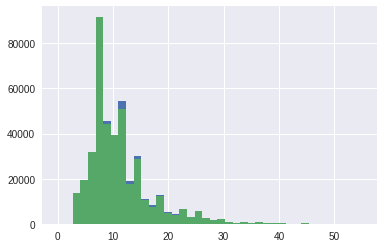

In [2]:
questions2 = train_df["question2"].values
length2 = np.array([len(x.split()) for x in questions2])
questions1 = train_df["question1"].values
length1 = np.array([len(x.split()) for x in questions1])
plt.figure()

plt.hist(length1,40,range=[0,55])
plt.hist(length2,40,range=[0,55])
plt.show()

In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 100


toke = Tokenizer()
toke.fit_on_texts(np.concatenate([questions1,questions2],axis=0))

sequences1 = toke.texts_to_sequences(questions1)
sequencesReverse1 = [s[::-1] for s in sequences1]
sequences2 = toke.texts_to_sequences(questions2)
sequencesReverse2 = [s[::-1] for s in sequences2]


word_index = toke.word_index
X_train_forward1 = pad_sequences(sequences1, maxlen=MAX_SEQUENCE_LENGTH)
X_train_reverse1 = pad_sequences(sequencesReverse1, maxlen=MAX_SEQUENCE_LENGTH)
X_train_forward2 = pad_sequences(sequences2, maxlen=MAX_SEQUENCE_LENGTH)
X_train_reverse2 = pad_sequences(sequencesReverse2, maxlen=MAX_SEQUENCE_LENGTH)

y_train = train_df["is_duplicate"].values #np_utils.to_categorical()


#load glove vectors
#download them from http://nlp.stanford.edu/data/glove.6B.zip
embeddings_index = {}
GLOVE_DIR = '/home/timomoeller/Programming/notebooks/rotten/glove.6B'
import os
f = open(os.path.join(GLOVE_DIR, 'glove.6B.%id.txt' %EMBEDDING_DIM))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))
#take only word vecs that are in training dictionary
#embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM)) # like that unable to learn unknown wordsembeddings 

embedding_matrix = np.random.uniform(-0.1,0.1,size=(len(word_index) + 1, EMBEDDING_DIM))
found = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        found +=1
        embedding_matrix[i] = embedding_vector
        
print('Using %i word vectors of total vocabulary size: %i ' %(found,len(word_index)))

Found 400000 word vectors.
Using 60337 word vectors of total vocabulary size: 95596


In [7]:
#LSTM with embedding trainable
from keras.models import Model
from keras.layers import Input
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Activation, Embedding, BatchNormalization
from keras.layers import LSTM
from keras.layers.merge import Concatenate
from keras.layers.advanced_activations import PReLU

opt = Adam(lr=0.001,beta_1=0.5)

#QUESTION1
inpONE_forward = Input(shape=X_train_forward1.shape[1:])
xf = Embedding(len(word_index) + 1,
              EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=True,
              input_shape=X_train_forward1.shape[1:])(inpONE_forward)
xf = LSTM(100, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)(xf)

inpONE_reverse = Input(shape=X_train_reverse1.shape[1:])
xr = Embedding(len(word_index) + 1,
              EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=True,
              input_shape=X_train_reverse1.shape[1:])(inpONE_reverse)
xr = LSTM(100, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)(xr)
x1 = Concatenate(axis=1)([xf,xr])



#QUESTION2
inpTWO_forward = Input(shape=X_train_forward2.shape[1:])
xf = Embedding(len(word_index) + 1,
              EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=True,
              input_shape=X_train_forward2.shape[1:])(inpTWO_forward)
xf = LSTM(100, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)(xf)

inpTWO_reverse = Input(shape=X_train_reverse2.shape[1:])
xr = Embedding(len(word_index) + 1,
              EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=True,
              input_shape=X_train_reverse2.shape[1:])(inpTWO_reverse)
xr = LSTM(100, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)(xr)
x2 = Concatenate(axis=1)([xf,xr])

# COMBINE
x = Concatenate(axis=1)([x1,x2])
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

x = Dense(500)(x)
x = PReLU()(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

x = Dense(500)(x)
x = PReLU()(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)
pred = Dense(1,activation='sigmoid')(x)

model = Model([inpONE_forward,inpONE_reverse,inpTWO_forward,inpTWO_reverse],pred)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 25)            0                                            
____________________________________________________________________________________________________
input_6 (InputLayer)             (None, 25)            0                                            
____________________________________________________________________________________________________
input_7 (InputLayer)             (None, 25)            0                                            
____________________________________________________________________________________________________
input_8 (InputLayer)             (None, 25)            0                                            
___________________________________________________________________________________________

In [10]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath="/home/timomoeller/Programming/kaggle/quora/tmp/weights.hdf5", verbose=1, save_best_only=True)

losses = model.fit([X_train_forward1,X_train_reverse1,X_train_forward2,X_train_reverse2],
                  y_train,
                  epochs=10,
                  batch_size=50,
                  verbose=1,
                  validation_split=0.1,
                  callbacks=[checkpointer])



test_df = test_df.fillna(" ")
test_questions1 = test_df["question1"].values
test_questions2 = test_df["question2"].values



seqsTest1 = toke.texts_to_sequences(test_questions1)
seqsTestReverse1 = [s[::-1] for s in seqsTest1]
X_test_forward1 = pad_sequences(seqsTest1, maxlen=MAX_SEQUENCE_LENGTH)
X_test_reverse1 = pad_sequences(seqsTestReverse1, maxlen=MAX_SEQUENCE_LENGTH)
seqsTest2 = toke.texts_to_sequences(test_questions2)
seqsTestReverse2 = [s[::-1] for s in seqsTest2]
X_test_forward2 = pad_sequences(seqsTest2, maxlen=MAX_SEQUENCE_LENGTH)
X_test_reverse2 = pad_sequences(seqsTestReverse2, maxlen=MAX_SEQUENCE_LENGTH)

preds = model.predict([X_test_forward1,X_test_reverse1,X_test_forward2,X_test_reverse2],batch_size=50,verbose=1)



test_df["is_duplicate"] = pd.Series(preds[:,0],index=test_df.index)
header = ["test_id", "is_duplicate"]
test_df.to_csv('submissions/predictions.csv', columns = header,index=False)

Train on 363861 samples, validate on 40429 samples
Epoch 1/10
363861/363861 [==============================] - 1312s - loss: 0.5362 - binary_accuracy: 0.7292 - val_loss: 0.4668 - val_binary_accuracy: 0.7697
Epoch 2/10
363861/363861 [==============================] - 1295s - loss: 0.4456 - binary_accuracy: 0.7892 - val_loss: 0.4304 - val_binary_accuracy: 0.7955
Epoch 3/10
363861/363861 [==============================] - 1296s - loss: 0.3959 - binary_accuracy: 0.8172 - val_loss: 0.4268 - val_binary_accuracy: 0.7945
Epoch 4/10
363861/363861 [==============================] - 1296s - loss: 0.3579 - binary_accuracy: 0.8381 - val_loss: 0.4290 - val_binary_accuracy: 0.8039
Epoch 5/10
363861/363861 [==============================] - 1297s - loss: 0.3269 - binary_accuracy: 0.8544 - val_loss: 0.4173 - val_binary_accuracy: 0.8072
Epoch 6/10
363861/363861 [==============================] - 1297s - loss: 0.3019 - binary_accuracy: 0.8671 - val_loss: 0.4524 - val_binary_accuracy: 0.8053
Epoch 7/10
36

Exception: Data must be 1-dimensional

In [13]:
test_df["is_duplicate"] = pd.Series(preds[:,0],index=test_df.index)
header = ["test_id", "is_duplicate"]
test_df.to_csv('submissions/predictions.csv', columns = header,index=False)

/home/timomoeller/.virtualenvs/keras/lib/python3.5/site-packages/matplotlib-2.0.0+3752.gd278160-py3.5-linux-x86_64.egg/matplotlib/legend.py:325: UserWarning: Unrecognized location "lower_left". Falling back on "best"; valid locations are
	center
	best
	center left
	center right
	upper right
	lower right
	lower left
	upper left
	lower center
	right
	upper center

  % (loc, '\n\t'.join(self.codes)))


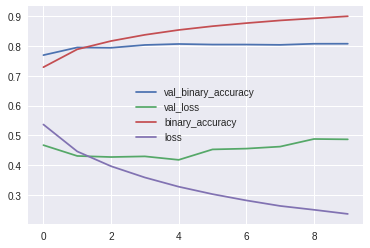

In [22]:
keys = list(losses.history.keys())
for key in keys:
    plt.plot(losses.history.get(key),label=key)
    
plt.legend(loc="lower_left")
plt.show()

(array([ 908200.,  161517.,  100090.,   74116.,   58764.,   48571.,
          42182.,   36937.,   33315.,   30441.,   28075.,   26161.,
          24582.,   23236.,   21968.,   21219.,   20522.,   20076.,
          19542.,   18886.,   18682.,   18477.,   18106.,   17970.,
          17999.,   17723.,   17357.,   17432.,   17494.,   17662.,
          17445.,   17487.,   18050.,   18225.,   18202.,   18663.,
          18956.,   18600.,   19023.,   19279.,   19500.,   19956.,
          20209.,   20657.,   20734.,   21991.,   23521.,   26520.,
          32538.,   58938.]),
 array([  6.66326994e-11,   1.99997950e-02,   3.99995900e-02,
          5.99993849e-02,   7.99991799e-02,   9.99989749e-02,
          1.19998770e-01,   1.39998565e-01,   1.59998360e-01,
          1.79998155e-01,   1.99997950e-01,   2.19997745e-01,
          2.39997540e-01,   2.59997335e-01,   2.79997129e-01,
          2.99996924e-01,   3.19996719e-01,   3.39996514e-01,
          3.59996309e-01,   3.79996104e-01,   3.999958

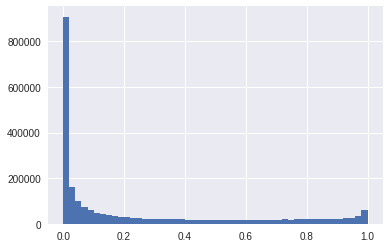

In [25]:
plt.hist(preds,50)

In [42]:
print(np.sum(preds<0.5)/preds.shape[0])
print(np.sum(y_train == 0)/y_train.shape[0])
idx = np.nonzero(preds>0.999)[0]
test_df.iloc[idx[:5],1:3].values

0.771438351843
0.630802146974


array([[ 'How will scrapping currency notes of INR 500 and INR 1000 will bring the black move deposited in Swiss bank accounts back to India?',
        'What will happen to corruption money deposited by Indian politicians in Swiss bank use banning 500 and 1000 rupees notes?'],
       ['How so I stop my Shepherd-Husky mix puppy from biting my shoes?',
        'How can I stop my Yorkie/Corgi mix from chewing my shoes?'],
       ['How can improve my oral English?',
        "How can españa' improve my spoken English?"],
       ['How do I use Jio australians in 3G devices?',
        'How can we man Jio sim in 3G phone?'],
       [ 'What will be the impact on real estate by banning 500 and 1000 rupee notes from India?',
        'What will be the effect of banning 500 & 1000 rupees notes on the real estate?']], dtype=object)